In [2]:
import pprint
import pickle
import psycopg2
import numpy as np
import pandas as pd

from datetime import date, timedelta
import time
from datetime import datetime
import datetime

from dateutil.parser import parse
import matplotlib.pyplot as plt
from pylab import *
import gensim
from gensim.models import CoherenceModel, HdpModel, LdaModel, LdaMulticore
import re, nltk, spacy
from collections import Counter

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
# Pre-process docs & make them tokenised
def pre_process_text(texts):
    texts = [re.sub(r'\S*@\S*\s?', '', text) for text in texts]
    texts = [re.sub(r'\s+', ' ', text) for text in texts]
    texts = [re.sub(r"\'", "", text) for text in texts]
    
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    texts = list(sent_to_words(texts))
    
    ## NLTK Stop words
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say']) 
    def remove_stopwords(sentences):
        return [[word for word in sentence if word not in stop_words] for sentence in sentences]
    texts = remove_stopwords(texts)
    
    ## Bigram stuff
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    texts = [bigram_mod[text] for text in texts]
    
    ## Lemmatization
    def lemmatization(sentences, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        docs = [nlp(" ".join(sentence)) for sentence in sentences] 
        return [[token.lemma_ for token in doc if token.pos_ in allowed_postags] for doc in docs]
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    texts = lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return texts

In [4]:
# Get LDA aspects for all articles ...
def getAspects(texts, lda_model):

    # pre-process texts & convert text to tokens
    pptxts = pre_process_text(texts)
    pptxts = [lda_model.id2word.doc2bow(pptxt) if pptxt else [] for pptxt in pptxts]
    
    # Then find lda aspects, pick scores > 0.3 if exists, else max
    probs = [lda_model[pptxt] for pptxt in pptxts]
    aspects = [[p[0] for p in prob if p[1]>=0.3] for prob in probs]
    for i in range(len(aspects)):
        if aspects[i] == []:
            aspects[i] = [max(probs[i], key=lambda y:y[1])[0]]
            
    return aspects

In [5]:
# Get locally stored downloaded Google Alert articles, find their aspects using LDA models same as those used for MM.
def getLocalRecs(lda_model_path, event_id, end_date):
    # Load LDA Model
    lda_model = LdaModel.load(lda_model_path)

    # Load data into recs; also filter articles shown in feed before/on end_date
    with open("google_records.pkl", "rb") as fp:
        google_records = pickle.load(fp)
    event_arts = google_records[(google_records[:,0]<=end_date) & (google_records[:,5]==event_id)]
    #event_arts = google_records[google_records[:,5]==event_id]
    
    recs = np.empty(shape = (0, 5))
    idx = 0
    for art in event_arts:
        recs = vstack( (recs, np.array([idx, [], art[2]+" -$- "+art[3], art[0], art[4]])) )
        idx += 1

    # Get all aspects and stitch
    aspects_col = getAspects(recs[:,2], lda_model)
    recs[:, 1] = aspects_col

    no_of_aspects = lda_model.num_topics
    return recs, no_of_aspects

## Get GA data - load articles, and find aspects using LDA models

In [6]:
# GA Start Data limit
start_date = datetime.date(2019, 2, 26)   #End Date-present
# Media End Data limit
end_date = datetime.date(2019, 8, 24)     #Start Date- 1/1/2011

## Thus all our further analysis happen within this limit.

In [7]:
aadhar_articles, aadhar_num_topics = \
getLocalRecs("../../../Base Implementation/aadharModel/aadhar.model", 0, end_date)

In [8]:
gst_articles, gst_num_topics = \
getLocalRecs("../../../Base Implementation/gstModel/gst.model", 1, end_date)

In [9]:
demonetization_articles, demonetization_num_topics = \
getLocalRecs("../../../Base Implementation/demonetizationModel/demonetization.model", 2, end_date)

In [10]:
farmers_articles, farmers_num_topics = \
getLocalRecs("../../../Base Implementation/farmersModel/farmers.model", 3, end_date)

## Load Mass Media Corpus

In [11]:
with open('../../../Base Implementation/records-aadhar.pkl', 'rb') as f:
    aadhar_records, _ = pickle.load(f)
with open('../../../Base Implementation/records-gst.pkl', 'rb') as f:
    gst_records, _ = pickle.load(f)
with open('../../../Base Implementation/records-demonetization.pkl', 'rb') as f:
    demonetization_records, _ = pickle.load(f)
with open('../../../Base Implementation/records-farmers.pkl', 'rb') as f:
    farmers_records, _ = pickle.load(f)
aadhar_records = aadhar_records[aadhar_records[:,3] >= start_date]
gst_records = gst_records[gst_records[:,3]>=start_date]
demonetization_records = demonetization_records[demonetization_records[:,3]>=start_date]
farmers_records = farmers_records[farmers_records[:,3]>=start_date]

## Eventwise Inventory Comparison

In [12]:
events = ["Aadhar","GST","Demonetization", "Farmers"]
num_ga = [len(aadhar_articles), len(gst_articles), len(demonetization_articles), len(farmers_articles)]
num_ma = [len(aadhar_records), len(gst_records), len(demonetization_records), len(farmers_records)]

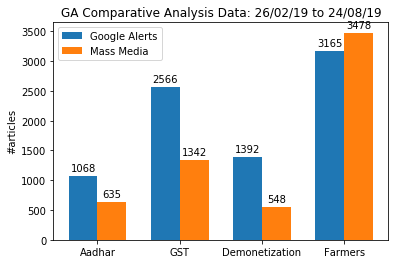

In [13]:
x = np.arange(len(events))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, num_ga, width, label='Google Alerts')
rects2 = ax.bar(x + width/2, num_ma, width, label='Mass Media')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#articles')
ax.set_title('GA Comparative Analysis Data: 26/02/19 to 24/08/19')
ax.set_xticks(x)
ax.set_xticklabels(events)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()

In [14]:
#Total Articles:
#GA
print(sum(num_ga))
#MA
print(sum(num_ma))

8191
6003


## Aspectwise Inventory Comparison

(0.920056242688962, 0.026806068403945487)
(0.6041108436879128, 0.04902305801251979)
(0.6028014356843503, 0.2819072172033728)
(0.7635847173911763, 1.4176548010036778e-05)


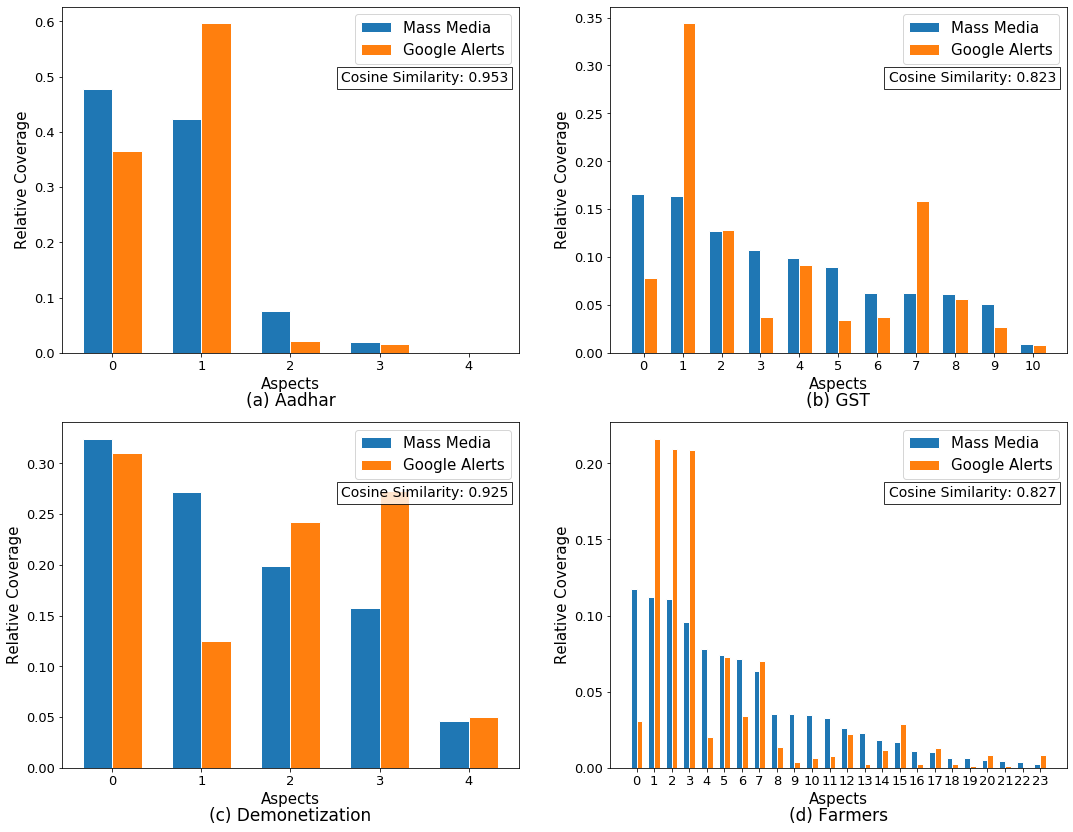

In [15]:
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.offsetbox import AnchoredText
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def asp_counts(articles, num_topics):
    ret = [0]*num_topics
    asp = np.vstack(articles)
    asp = np.sum(asp[:,1])
    total = len(asp)
    ret = [asp.count(i)/total for i, x in enumerate(ret)]
    return ret

def plotAspectDistribution(events, num_topics, ga_articles, ma_articles):
    figs, axes = plt.subplots(2, 2, figsize=(18, 14))
    for i in range(2):
        for j in range(2):
            k = 2*i + j
            ga_asp_dist = asp_counts(ga_articles[k], num_topics[k])
            ma_asp_dist = asp_counts(ma_articles[k], num_topics[k])
            
            #from IPython import embed; embed()
            ga_asp_dist = [x for _,x in sorted( zip(ma_asp_dist, ga_asp_dist))]
            ga_asp_dist.reverse()
            ma_asp_dist.sort(reverse=True)
            
            barWidth = 0.33
            ticks = np.arange(num_topics[k])
            r2 = [x + barWidth/2 for x in ticks]
            r1 = [x - barWidth/2 for x in ticks]
            axes[i][j].bar(r1, ma_asp_dist, width = barWidth, edgecolor='white', label='Mass Media')
            axes[i][j].bar(r2, ga_asp_dist, width = barWidth, edgecolor='white', label='Google Alerts')
            axes[i][j].xaxis.set_ticks(ticks)
            axes[i][j].legend(prop={'size': 15})
            
            norm_ga = np.array(ga_asp_dist)
            norm_ma = np.array(ma_asp_dist)
            cos_sim = cosine_similarity(norm_ga.reshape(1,-1), norm_ma.reshape(1,-1))
            print(pearsonr(norm_ga, norm_ma))
            cos_sim = 'Cosine Similarity: %.3f'%cos_sim
            text(0.61, 0.775, cos_sim,
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 size=14,
                 bbox=dict(facecolor='none', edgecolor='black', fc="w", alpha=0.8),
                 transform = axes[i][j].transAxes)
            
            axes[i][j].tick_params(axis='both', which='major', labelsize=13)
            axes[i][j].set_xlabel("Aspects", size=15)
            axes[i][j].set_ylabel("Relative Coverage", size=15)
            axes[i][j].set_title('(' + chr(ord('a')+k) +') ' +events[k] , y=-0.17, size=17 )

    figs.savefig('graphs/GAvsMM.png', bbox_inches='tight')

events = ['Aadhar', 'GST', 'Demonetization', 'Farmers']
num_topics = [aadhar_num_topics, gst_num_topics, demonetization_num_topics, farmers_num_topics]
ga_articles = [aadhar_articles, gst_articles, demonetization_articles, farmers_articles]
mass_articles = [aadhar_records, gst_records, demonetization_records, farmers_records]

plotAspectDistribution(events, num_topics, ga_articles, mass_articles)

## Analysing Recommendation Algorithms - Fairness, Diversity & Recency Trends

### 1. Random Selection
### 2. Fresh Selection
### 3. Our Fairness & Diversity Heuristic
### 4. Google Alerts

In [16]:
def getAchievedRelDist(feed_list, no_of_aspects, feed_dates=None, time=None):
    ret = [0]*no_of_aspects
    
    #Filter articles based on feed-produce date -- optional
    if(feed_dates is None):
        feed_list = np.vstack(feed_list)
    else:
        oldest_date = feed_dates[-1] - timedelta(time=time)
        list_of_indices = [idx for idx, val in enumerate(feed_dates) if val >= oldest_date]
        feed_list = [feed_list[idx] for idx in list_of_indices]
    
    #Count each aspect
    total_list = np.vstack(feed_list)
    allAspectsProduced = np.sum(total_list[:,1])
    #Sum total
    total_all_aspects = len(allAspectsProduced)
    
    ret = [allAspectsProduced.count(i)/total_all_aspects for i, x in enumerate(ret)]
    return np.array(ret)

def getGINI(feeds, no_of_aspects):
    feed = np.vstack(feeds)
    
    if len(feed) == 0:
        return 0
    
    # Count each aspect
    x = np.sum(feed[:,1])
    freq = Counter(x)
    vals = [freq[val] for val in range(no_of_aspects)]
    
    # Taken from Stack Overflow
    vals = np.asarray(vals)
    sorted_vals = np.sort(vals)
    n = len(vals)
    cumvals = np.cumsum(sorted_vals, dtype=float)
    # The above formula, with all weights equal to 1 simplifies to:
    gini_val = (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n
    
    return gini_val

def getHHI(feeds, no_of_aspects):
    #feeds = np.array()
    feed = np.vstack(feeds)
    if len(feed) == 0:
        return 0 
    
    dist = getAchievedRelDist([feed], no_of_aspects)
    score = np.sum(dist**2)
    return score

def getAges(feeds):
    if(len(feeds) == 0):
        return 0
    feed = np.vstack(feeds)
    ages = feeds[:,3][feeds[:,4] != None] - feeds[:,4][feeds[:,4] != None]
    ages = ages/timedelta(days=1)
    ages = ages[(ages>=0) & (ages<=100) ]
    if(len(ages) == 0):
        return 0
    return np.mean(ages)

In [17]:
def daterange(st, en):
    for n in range(int ((en - st).days)+1):
        yield st + timedelta(n)
start, end = start_date, end_date

In [20]:
#Sub routine to plot GINI & HHI comparisons
def plotGH(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_HHI, feed_HHI_rnd, feed_HHI_fr, feed_HHI_hr,\
           GA_GINI, feed_GINI_rnd, feed_GINI_fr, feed_GINI_hr):
    
    figs, axes = plt.subplots(1, 2, figsize=(18, 6))
    figs.suptitle(event_name.title(), size=20 )
    plt.rc('legend',fontsize=13)

    # Plot HHIs
    axes[0].set_xlabel("Feed Date", size=14)
    axes[0].set_ylabel("HHI Value", size=14)
    axes[0].set_title("Short Term Diversity", size=15)
    axes[0].plot(GA_dates, GA_HHI, label='GA (Median: %.3f)'%np.median(GA_HHI) )
    axes[0].plot(feed_dates_rnd, feed_HHI_rnd, label='Random (Median: %.3f)'%np.median(feed_HHI_rnd) )
    axes[0].plot(feed_dates_fr, feed_HHI_fr, label='Latest (Median: %.3f)'%np.median(feed_HHI_fr) )
    axes[0].plot(feed_dates_hr, feed_HHI_hr, label='f=0.5, d=0.8 (Median: %.3f)'%np.median(feed_HHI_hr) )
    axes[0].tick_params(axis='both', which='major', labelsize=13)
    axes[0].legend()
    #axes[0].legend(prop={'size': 13}, loc=1)


    # Plot GINIs
    axes[1].set_xlabel("Feed Date", size=14)
    axes[1].set_ylabel("GINI Value", size=14)
    axes[1].set_title("Long Term Fairness", size=15)
    axes[1].plot(GA_dates, GA_GINI, label='GA (Median: %.3f)'%np.median(GA_GINI) )
    axes[1].plot(feed_dates_rnd, feed_GINI_rnd, label='Random (Median: %.3f)'%np.median(feed_GINI_rnd) )
    axes[1].plot(feed_dates_fr, feed_GINI_fr, label='Latest (Median: %.3f)'%np.median(feed_GINI_fr) )
    axes[1].plot(feed_dates_hr, feed_GINI_hr, label='f=0.5, d=0.8 (Median: %.3f)'%np.median(feed_GINI_hr) )
    axes[1].tick_params(axis='both', which='major', labelsize=13)
    axes[1].legend()
    #axes[1].legend(prop={'size': 13}, loc=1)

    figs.savefig('graphs/'+event_name+'_fairness_diversity_GA.png', bbox_inches='tight')

In [21]:
#Sub routine to plot recency comparison
def plotRec(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_AGE, feed_AGE_rnd, feed_AGE_fr, feed_AGE_hr):
    
    #Age of articles
    figs, axes = plt.subplots(1, 1, figsize=(9, 6))
    plt.rc('legend',fontsize=13)

    df_GA = pd.DataFrame(GA_AGE, index=GA_dates)
    df_GA = df_GA.rolling(window=15).mean()
    df_rnd = pd.DataFrame(feed_AGE_rnd, index=feed_dates_rnd)
    df_rnd = df_rnd.rolling(window=15).mean()
    df_fr = pd.DataFrame(feed_AGE_fr, index=feed_dates_fr)
    df_fr = df_fr.rolling(window=15).mean()
    df_hr = pd.DataFrame(feed_AGE_hr, index=feed_dates_hr)
    df_hr = df_hr.rolling(window=15).mean()

    axes.set_xlabel("Feed Date", size=14)
    axes.set_ylabel("Feed Age", size=14)
    axes.set_title(event_name.title()+": Average Feed Age",size=15 )
    axes.plot(df_GA.index, df_GA, label='GA (Median: %.3f)'%np.median(GA_AGE) )
    axes.plot(df_rnd.index, df_rnd, label='Random (Median: %.3f)'%np.median(feed_AGE_rnd) )
    axes.plot(df_fr.index, df_fr, label='Latest (Median: %.3f)'%np.median(feed_AGE_fr) )
    axes.plot(df_hr.index, df_hr, label='f=0.5, d=0.8 (Median: %.3f)'%np.median(feed_AGE_hr) )
    axes.tick_params(axis='both', which='major', labelsize=13)
    axes.legend()

    figs.savefig('graphs/'+event_name+'_recency_GA.png', bbox_inches='tight')

### For Aadhar

In [22]:
GA_dates, GA_HHI, GA_GINI, GA_AGE = [], [], [], []
for dt in daterange(start_date, end_date):
    GA_dates.append(dt)
    GA_HHI.append(getHHI( aadhar_articles[(aadhar_articles[:,3] <= dt) & \
                                         (aadhar_articles[:,3]>=(dt-timedelta(14)))], aadhar_num_topics))
    GA_GINI.append(getGINI( aadhar_articles[(aadhar_articles[:,3] <= dt) & \
                                         (aadhar_articles[:,3]>=(dt-timedelta(89)))], aadhar_num_topics))
    GA_AGE.append(getAges( aadhar_articles[(aadhar_articles[:,3] == dt)] ))

In [23]:
### Get My Feed Data
with open("../../../Base Implementation/GAComparisonData/aadhar_rnd3.pkl", "rb") as fp:
        aadhar_rnd, feed_dates_rnd, feed_HHI_rnd, feed_GINI_rnd, feed_AGE_rnd = pickle.load(fp)
feed_dates_rnd = np.array(feed_dates_rnd)
feed_HHI_rnd = np.array(feed_HHI_rnd)
feed_GINI_rnd = np.array(feed_GINI_rnd)
feed_AGE_rnd = np.array(feed_AGE_rnd)
aadhar_rnd = np.array(aadhar_rnd)

aadhar_rnd = aadhar_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_HHI_rnd = feed_HHI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_GINI_rnd = feed_GINI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_AGE_rnd = feed_AGE_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_dates_rnd = feed_dates_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]

with open("../../../Base Implementation/GAComparisonData/aadhar_fr3.pkl", "rb") as fp:
        aadhar_fr, feed_dates_fr, feed_HHI_fr, feed_GINI_fr, feed_AGE_fr = pickle.load(fp)
feed_dates_fr = np.array(feed_dates_fr)
feed_HHI_fr = np.array(feed_HHI_fr)
feed_GINI_fr = np.array(feed_GINI_fr)
feed_AGE_fr = np.array(feed_AGE_fr)
aadhar_fr = np.array(aadhar_fr)

aadhar_fr = aadhar_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_HHI_fr = feed_HHI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_GINI_fr = feed_GINI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_AGE_fr = feed_AGE_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_dates_fr = feed_dates_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]


with open("../../../Base Implementation/GAComparisonData/aadhar_hr3.pkl", "rb") as fp:
        aadhar_hr, feed_dates_hr, feed_HHI_hr, feed_GINI_hr, feed_AGE_hr = pickle.load(fp)
feed_dates_hr = np.array(feed_dates_hr)
feed_HHI_hr = np.array(feed_HHI_hr)
feed_GINI_hr = np.array(feed_GINI_hr)
feed_AGE_hr = np.array(feed_AGE_hr)
aadhar_hr = np.array(aadhar_hr)

aadhar_hr = aadhar_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_HHI_hr = feed_HHI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_GINI_hr = feed_GINI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_AGE_hr = feed_AGE_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_dates_hr = feed_dates_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]

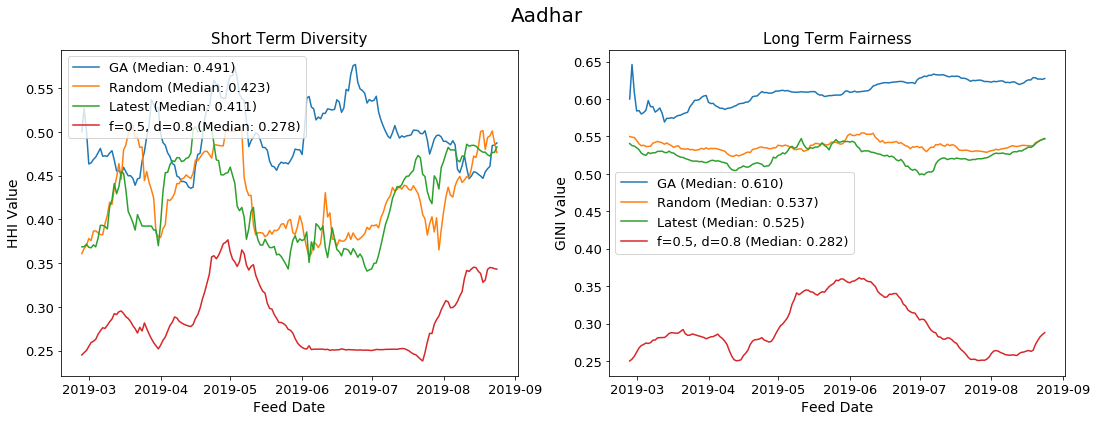

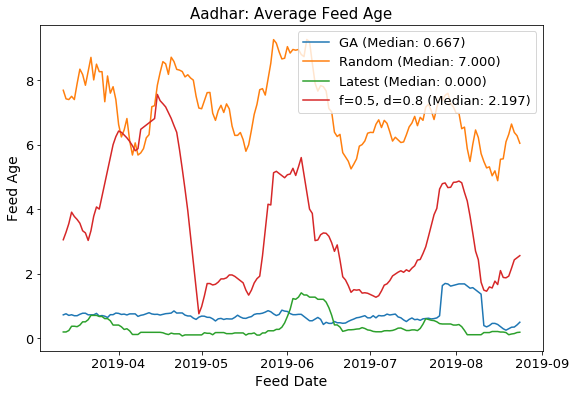

In [25]:
event_name = "aadhar"
plotGH(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_HHI, feed_HHI_rnd, feed_HHI_fr, feed_HHI_hr,\
           GA_GINI, feed_GINI_rnd, feed_GINI_fr, feed_GINI_hr)

plotRec(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_AGE, feed_AGE_rnd, feed_AGE_fr, feed_AGE_hr)

### GA GST

In [26]:
GA_dates, GA_HHI, GA_GINI, GA_AGE = [], [], [], []
for dt in daterange(start, end):
    GA_dates.append(dt)
    GA_HHI.append(getHHI( gst_articles[(gst_articles[:,3] <= dt) & \
                                         (gst_articles[:,3]>=(dt-timedelta(14)))], gst_num_topics))
    GA_GINI.append(getGINI( gst_articles[(gst_articles[:,3] <= dt) & \
                                         (gst_articles[:,3]>=(dt-timedelta(89)))],gst_num_topics))
    GA_AGE.append(getAges( gst_articles[(gst_articles[:,3] == dt)] ))

In [27]:
### Get My Data indices
with open("../../../Base Implementation/GAComparisonData/gst_rnd3.pkl", "rb") as fp:
        gst_rnd, feed_dates_rnd, feed_HHI_rnd, feed_GINI_rnd, feed_AGE_rnd = pickle.load(fp)
feed_dates_rnd = np.array(feed_dates_rnd)
feed_HHI_rnd = np.array(feed_HHI_rnd)
feed_GINI_rnd = np.array(feed_GINI_rnd)
feed_AGE_rnd = np.array(feed_AGE_rnd)
gst_rnd = np.array(gst_rnd)

gst_rnd = gst_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_HHI_rnd = feed_HHI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_GINI_rnd = feed_GINI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_AGE_rnd = feed_AGE_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_dates_rnd = feed_dates_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]


with open("../../../Base Implementation/GAComparisonData/gst_fr3.pkl", "rb") as fp:
        gst_fr, feed_dates_fr, feed_HHI_fr, feed_GINI_fr, feed_AGE_fr = pickle.load(fp)
feed_dates_fr = np.array(feed_dates_fr)
feed_HHI_fr = np.array(feed_HHI_fr)
feed_GINI_fr = np.array(feed_GINI_fr)
feed_AGE_fr = np.array(feed_AGE_fr)
gst_fr = np.array(gst_fr)

gst_fr = gst_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_HHI_fr = feed_HHI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_GINI_fr = feed_GINI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_AGE_fr = feed_AGE_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_dates_fr = feed_dates_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]


with open("../../../Base Implementation/GAComparisonData/gst_hr3.pkl", "rb") as fp:
        gst_hr, feed_dates_hr, feed_HHI_hr, feed_GINI_hr, feed_AGE_hr = pickle.load(fp)
feed_dates_hr = np.array(feed_dates_hr)
feed_HHI_hr = np.array(feed_HHI_hr)
feed_GINI_hr = np.array(feed_GINI_hr)
feed_AGE_hr = np.array(feed_AGE_hr)
gst_hr = np.array(gst_hr)

gst_hr = gst_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_HHI_hr = feed_HHI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_GINI_hr = feed_GINI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_AGE_hr = feed_AGE_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_dates_hr = feed_dates_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]

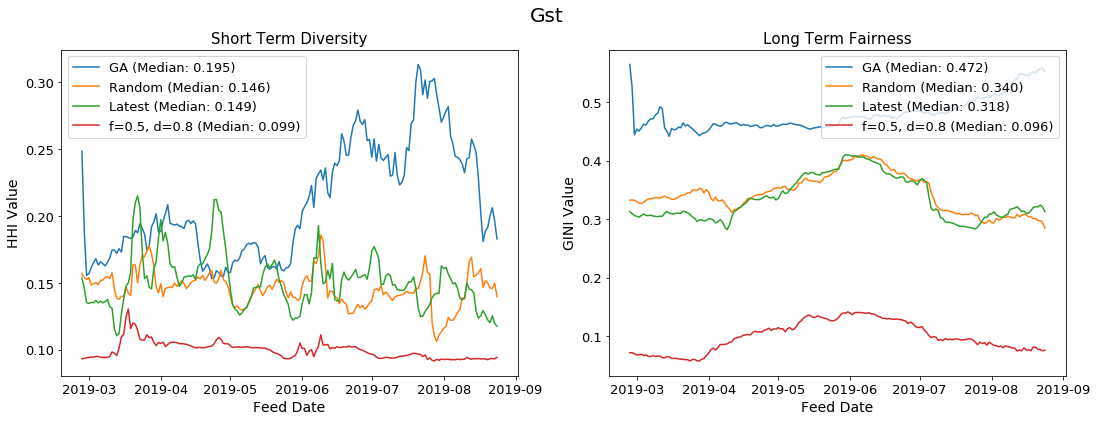

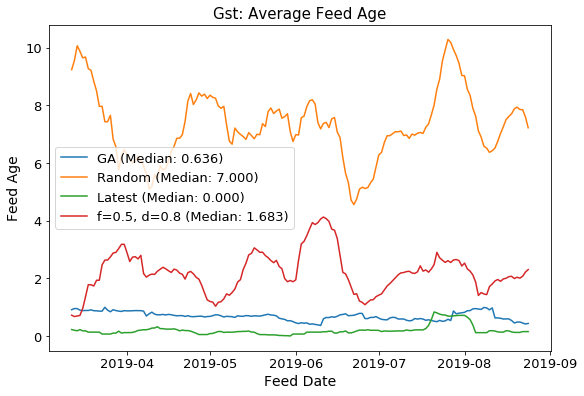

In [30]:
event_name = "GST"
plotGH(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_HHI, feed_HHI_rnd, feed_HHI_fr, feed_HHI_hr,\
           GA_GINI, feed_GINI_rnd, feed_GINI_fr, feed_GINI_hr)

plotRec(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_AGE, feed_AGE_rnd, feed_AGE_fr, feed_AGE_hr)

### GA Demonetisation

In [31]:
GA_dates, GA_HHI, GA_GINI, GA_AGE = [], [], [], []
for dt in daterange(start, end):
    GA_dates.append(dt)
    GA_HHI.append(getHHI( demonetization_articles[(demonetization_articles[:,3] <= dt) & \
                                         (demonetization_articles[:,3]>=(dt-timedelta(14)))], demonetization_num_topics))
    GA_GINI.append(getGINI( demonetization_articles[(demonetization_articles[:,3] <= dt) & \
                                         (demonetization_articles[:,3]>=(dt-timedelta(89)))],demonetization_num_topics))
    GA_AGE.append(getAges( demonetization_articles[(demonetization_articles[:,3] == dt)] ))

In [32]:
### Get My Data indices
with open("../../../Base Implementation/GAComparisonData/demonetization_rnd3.pkl", "rb") as fp:
        demonetization_rnd, feed_dates_rnd, feed_HHI_rnd, feed_GINI_rnd, feed_AGE_rnd = pickle.load(fp)
feed_dates_rnd = np.array(feed_dates_rnd)
feed_HHI_rnd = np.array(feed_HHI_rnd)
feed_GINI_rnd = np.array(feed_GINI_rnd)
feed_AGE_rnd = np.array(feed_AGE_rnd)
demonetization_rnd = np.array(demonetization_rnd)

demonetization_rnd = demonetization_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_HHI_rnd = feed_HHI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_GINI_rnd = feed_GINI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_AGE_rnd = feed_AGE_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_dates_rnd = feed_dates_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]

with open("../../../Base Implementation/GAComparisonData/demonetization_fr3.pkl", "rb") as fp:
        demonetization_fr, feed_dates_fr, feed_HHI_fr, feed_GINI_fr, feed_AGE_fr = pickle.load(fp)
feed_dates_fr = np.array(feed_dates_fr)
feed_HHI_fr = np.array(feed_HHI_fr)
feed_GINI_fr = np.array(feed_GINI_fr)
feed_AGE_fr = np.array(feed_AGE_fr)
demonetization_fr = np.array(demonetization_fr)

demonetization_fr = demonetization_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_HHI_fr = feed_HHI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_GINI_fr = feed_GINI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_AGE_fr = feed_AGE_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_dates_fr = feed_dates_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]

with open("../../../Base Implementation/GAComparisonData/demonetization_hr3.pkl", "rb") as fp:
        demonetization_hr, feed_dates_hr, feed_HHI_hr, feed_GINI_hr, feed_AGE_hr = pickle.load(fp)
feed_dates_hr = np.array(feed_dates_hr)
feed_HHI_hr = np.array(feed_HHI_hr)
feed_GINI_hr = np.array(feed_GINI_hr)
feed_AGE_hr = np.array(feed_AGE_hr)
demonetization_hr = np.array(demonetization_hr)

demonetization_hr = demonetization_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_HHI_hr = feed_HHI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_GINI_hr = feed_GINI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_AGE_hr = feed_AGE_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_dates_hr = feed_dates_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]

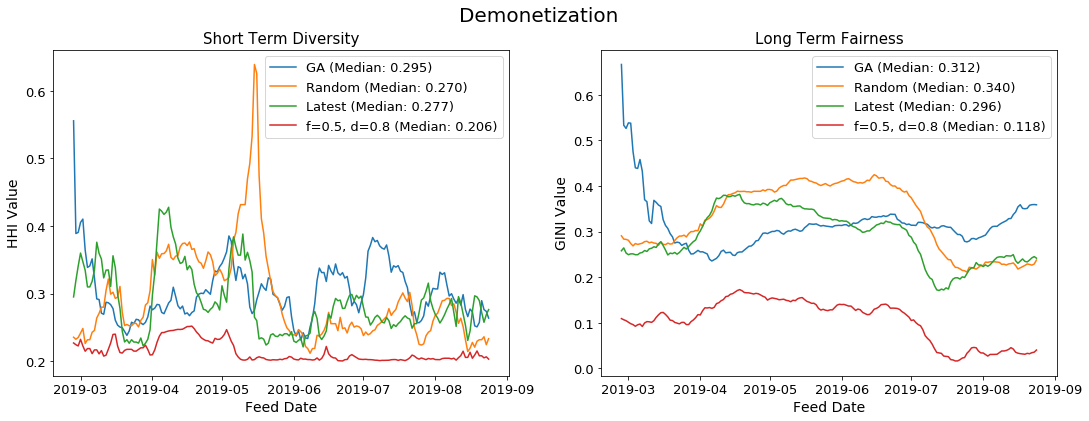

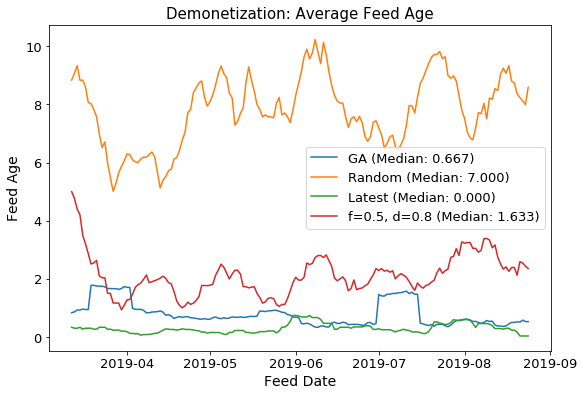

In [33]:
event_name = "demonetization"
plotGH(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_HHI, feed_HHI_rnd, feed_HHI_fr, feed_HHI_hr,\
           GA_GINI, feed_GINI_rnd, feed_GINI_fr, feed_GINI_hr)

plotRec(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_AGE, feed_AGE_rnd, feed_AGE_fr, feed_AGE_hr)

### Farmers

In [180]:
GA_dates, GA_HHI, GA_GINI, GA_AGE = [], [], [], []
for dt in daterange(start, end):
    GA_dates.append(dt)
    GA_HHI.append(getHHI( farmers_articles[(farmers_articles[:,3] <= dt) & \
                                         (farmers_articles[:,3]>=(dt-timedelta(14)))], farmers_num_topics))
    GA_GINI.append(getGINI( farmers_articles[(farmers_articles[:,3] <= dt) & \
                                         (farmers_articles[:,3]>=(dt-timedelta(89)))],farmers_num_topics))
    GA_AGE.append(getAges( farmers_articles[(farmers_articles[:,3] == dt)] ))

In [181]:
### Get My Data indices
with open("../../../Base Implementation/GAComparisonData/farmers_rnd3.pkl", "rb") as fp:
        farmers_rnd, feed_dates_rnd, feed_HHI_rnd, feed_GINI_rnd, feed_AGE_rnd = pickle.load(fp)
feed_dates_rnd = np.array(feed_dates_rnd)
feed_HHI_rnd = np.array(feed_HHI_rnd)
feed_GINI_rnd = np.array(feed_GINI_rnd)
feed_AGE_rnd = np.array(feed_AGE_rnd)
farmers_rnd = np.array(farmers_rnd)

farmers_rnd = farmers_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_HHI_rnd = feed_HHI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_GINI_rnd = feed_GINI_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_AGE_rnd = feed_AGE_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]
feed_dates_rnd = feed_dates_rnd[(feed_dates_rnd[:] <=end) & (feed_dates_rnd[:]>=start)]

with open("../../../Base Implementation/GAComparisonData/farmers_fr3.pkl", "rb") as fp:
        farmers_fr, feed_dates_fr, feed_HHI_fr, feed_GINI_fr, feed_AGE_fr = pickle.load(fp)
feed_dates_fr = np.array(feed_dates_fr)
feed_HHI_fr = np.array(feed_HHI_fr)
feed_GINI_fr = np.array(feed_GINI_fr)
feed_AGE_fr = np.array(feed_AGE_fr)
farmers_fr = np.array(farmers_fr)

farmers_fr = farmers_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_HHI_fr = feed_HHI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_GINI_fr = feed_GINI_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_AGE_fr = feed_AGE_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]
feed_dates_fr = feed_dates_fr[(feed_dates_fr[:] <=end) & (feed_dates_fr[:]>=start)]

with open("../../../Base Implementation/GAComparisonData/farmers_hr3.pkl", "rb") as fp:
        farmers_hr, feed_dates_hr, feed_HHI_hr, feed_GINI_hr, feed_AGE_hr = pickle.load(fp)
feed_dates_hr = np.array(feed_dates_hr)
feed_HHI_hr = np.array(feed_HHI_hr)
feed_GINI_hr = np.array(feed_GINI_hr)
feed_AGE_hr = np.array(feed_AGE_hr)
farmers_hr = np.array(farmers_hr)

farmers_hr = farmers_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_HHI_hr = feed_HHI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_GINI_hr = feed_GINI_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_AGE_hr = feed_AGE_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]
feed_dates_hr = feed_dates_hr[(feed_dates_hr[:] <=end) & (feed_dates_hr[:]>=start)]

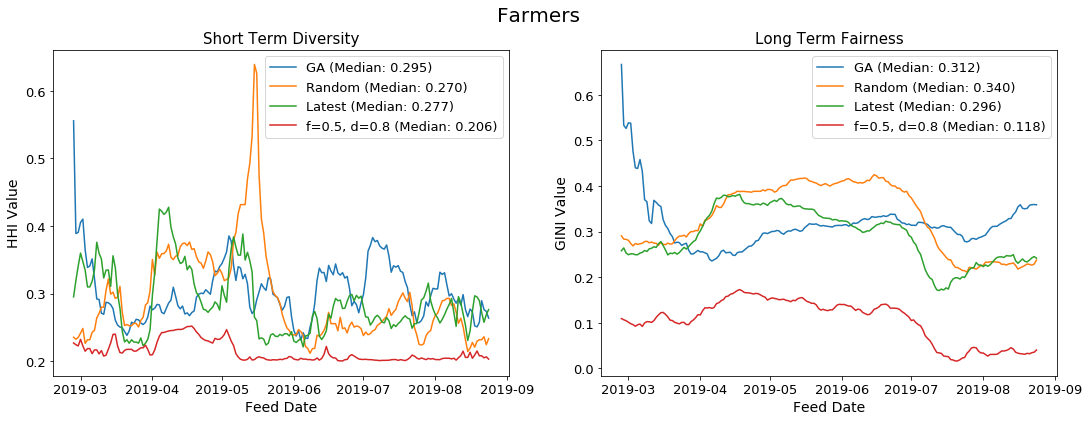

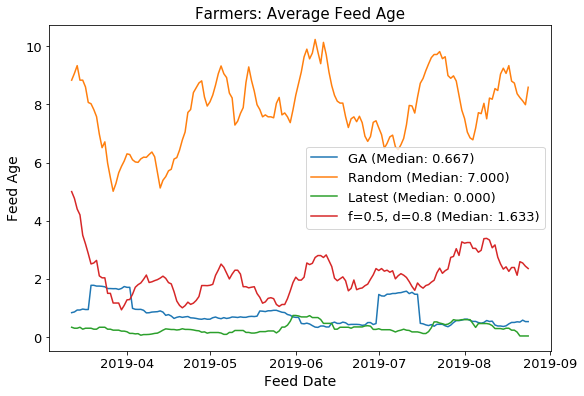

In [34]:
event_name = "farmers"
plotGH(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_HHI, feed_HHI_rnd, feed_HHI_fr, feed_HHI_hr,\
           GA_GINI, feed_GINI_rnd, feed_GINI_fr, feed_GINI_hr)

plotRec(event_name, GA_dates, feed_dates_rnd, feed_dates_fr, feed_dates_hr,\
           GA_AGE, feed_AGE_rnd, feed_AGE_fr, feed_AGE_hr)

## Comparison of recommendation schemes for _repetition_

In [40]:
#Repition-at-K
def repAtk(articles, group_i=2, ga=True, mass=None):
    if not ga:
        df=makeDf(articles)
    else:
        df = pd.DataFrame(articles)
    df['k']=df.groupby([group_i])[group_i].transform('count')
    
    ret_val = np.array([0])
    ret_ind = np.array([0])
    
    k=1
    max_k = df['k'].max()
    for k in range(1, max_k+1):
        succ = len(df[df['k']==k])/k
        #print(succ)
        if succ >= 2:
            ret_val = np.append(ret_val, succ)
            ret_ind = np.append(ret_ind, k)
        
    if(not ga):
        ret_val[0]=untouched(mass, df)
    else:
        ret_val = ret_val[1:]
        ret_ind = ret_ind[1:]
    
    # To normalise or to not
    ret_val = ret_val/np.sum(ret_val)
    
    return ret_ind, ret_val 

def makeDf(feeds):
    df = pd.DataFrame(columns=[1,2,3,4,5])
    for i, feed in enumerate(feeds):
        for j, art in enumerate(feed):
            df = df.append({1:i, 2:art[0], 3:art[1], 4:art[2], 5:art[3]}, ignore_index=True)
    return df

#Find how much was the corpus untouched
def untouched(mass, feed_df):
    mass = mass[:,0]
    ret=0
    feed_df = list(feed_df[2])
    for aid in mass:
        if aid not in feed_df:
            ret+=1
    return ret

In [41]:
def plotFor(event,save_name, mass, ga, rnd, fr, hr):
    plt.title(event + ': Probability of an article repeating k times')
    plt.xlabel('k')
    plt.ylabel('Probability')
    
    plt.plot(*repAtk(ga), label='Google Alerts', marker='o', linestyle='--')
    plt.plot(*repAtk(rnd, ga=False, mass=mass), label='Random', marker='.', linestyle='-')
    plt.plot(*repAtk(fr, ga=False, mass=mass), label='Latest Selection', marker='*', linestyle='-.')
    plt.plot(*repAtk(hr, ga=False, mass=mass), label='Heuristic: f=0.5, d=0.8', marker='^', linestyle=':')
    plt.legend()
    plt.savefig('graphs/' + save_name + '_repetition_GA2.png', bbox_inches='tight')
    plt.show()

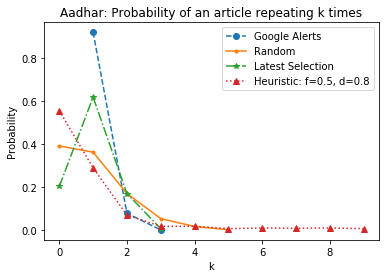

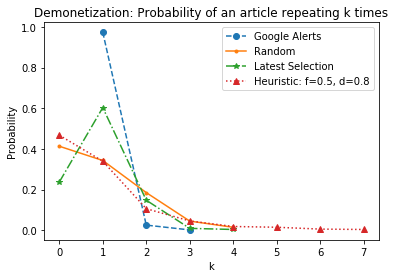

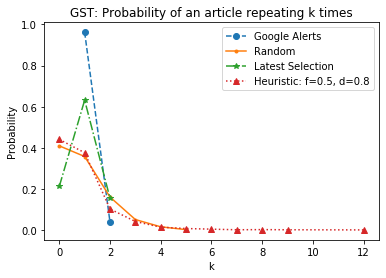

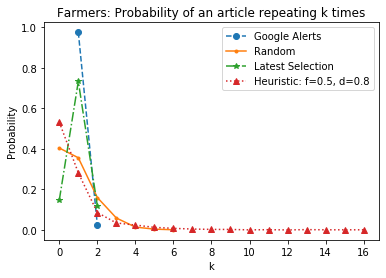

In [42]:
plotFor('Aadhar','aadhaar', aadhar_records, aadhar_articles, aadhar_rnd, aadhar_fr, aadhar_hr)
plotFor('Demonetization','demon', demonetization_records, demonetization_articles, demonetization_rnd, demonetization_fr, demonetization_hr)
plotFor('GST','gst', gst_records, gst_articles, gst_rnd, gst_fr, gst_hr)
plotFor('Farmers','farmers', farmers_records, farmers_articles, farmers_rnd, farmers_fr, farmers_hr)